In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=替换为Qwen API Key

In [2]:
%%capture --no-stderr
!pip install -U umap-learn langchain langchain-community langchain-openai langchain-cohere pypdf sentence_transformers chromadb shutil openpyxl FlagEmbedding cohere

In [4]:
import os
import pandas as pd

In [5]:
expr_version = 'retrieval_v12_partor'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档准备

## 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [10]:
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)

In [11]:
from langchain.llms import Ollama

embd = get_embeddings(model_path)
model = Ollama(
    model='qwen2:7b-instruct-32k',
    base_url='http://localhost:11434',
    top_k=1 # 为了使结果可复现，正常使用不需要设置
)

以下这段代码，来自Langchain官方示例：https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

In [12]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Language doc. 
    
    LangChain Expression Language provides a way to compose chain in LangChain.
    
    Give a detailed summary of the documentation provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [13]:
leaf_texts = [doc.page_content for doc in splitted_docs]
summarize_dict = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 10 clusters--


--Generated 1 clusters--


In [14]:
all_texts = leaf_texts.copy()

for level in sorted(summarize_dict.keys()):
    summaries = summarize_dict[level][1]['summaries'].tolist()
    all_texts.extend(summaries)

In [15]:
vector_db = Chroma.from_texts(texts=all_texts, embedding=embd)

In [16]:
print(vector_db.similarity_search('2023年全球经济增长的特点是什么？')[0].page_content)

LangChain Expression Language 的文档提供了一个关于全球宏观经济金融展望的概述，主要关注了以下几个关键点：

1. **全球经济复苏不均衡**：报告指出全球经济复苏存在显著差异。发达经济体（如欧元区和英国）的增长速度明显放缓，预计2023年增速较前一年下降约1个百分点。相比之下，新兴经济体的增长与2022年大致持平。

2. **区域经济表现**：
   - **发达经济体**：报告分析了不同地区的经济表现，指出美国在主要发达经济体中相对较好，而欧元区和英国的GDP环比增速在三季度转为负增长。
   - **新兴经济体**：东南亚等出口型经济体的增长压力较大，拉美、非洲等大宗商品出口国的增速放缓。中东欧国家的经济增长有所加快。

3. **需求端分析**：
   - **内需支撑**：发达经济体中，美国消费未受加息明显影响，私人消费维持稳定增长，并对经济增长贡献显著（64.4%）。欧洲各国消费指数整体稳定，但随着高利率和通胀的影响逐渐显现，内需增长动力减弱。
   - **投资情况**：发达经济体的投资受到加息政策的较大影响。美国私人投资在一季度触底后反弹，三季度存货及住宅投资恢复增长，但制造业和设备投资放缓。欧盟投资增速放缓，房地产投资减少。

4. **国际贸易与跨境投资**：
   - 全球货物贸易量和价格指数均承压下行，主要经济体出口贸易同比增速下降。
   - 跨境直接投资预计将继续下行，但降幅较2022年有所收窄。在地缘政治局势紧张、金融领域动荡加剧等背景下，并购交易疲软。

5. **展望2024年**：
   - 预计全球经济复苏将保持疲软态势，且分化可能加剧。
   - 发达经济体面临“遏通胀和稳增长”的两难问题，货币政策走势将出现分化。预计美联储在2024年上半年停止加息，日本央行可能退出负利率政策。
   - 各国经济走势将进一步分化，相较于新兴市场和发展中经济体，发达经济体面临更大的经济增长压力。

6. **需求端与生产端**：报告指出需求端下行压力可能大于生产端。全球工业生产在触底后缓慢回升，预计2024年供应链和工业生产将继续波动中的复苏。然而，在高通胀、高利率、高债务背景下，居民家庭资产负债表状况将变差。

7. **稳定因素与经济托底**：随着供应链和工业生产的逐步恢复正常，全球供求形势将持续改善。主要经

# 生成答案

In [17]:
import time

def rag(llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

## 预测

In [18]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct-32k',
    base_url='http://localhost:11434',
    top_k=1
)

In [19]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
        
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [20]:
save_path = os.path.join(expr_dir, 'predictions.pkl')

if os.path.exists(save_path):
    pred_dfs = pickle.load(open(save_path, 'rb'))
else:
    pred_dfs = {}

In [21]:
n_chunks_arr = range(1, 9)

for n_chunks in tqdm(n_chunks_arr):
    if n_chunks in pred_dfs:
        continue

    print(f"n_chunks={n_chunks}")
    pred_dfs[n_chunks] = predict(ollama_llm, prediction_df, n_chunks=n_chunks)

  0%|          | 0/8 [00:00<?, ?it/s]

n_chunks=1


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=2


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=3


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=4


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=5


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=6


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=7


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=8


  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
pred_dfs.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

In [23]:
save_path = os.path.join(expr_dir, 'pred_dfs.pkl')

if not os.path.exists(save_path):
    print(f'saving to {save_path}')
    pickle.dump(pred_dfs, open(save_path, 'wb'))

saving to ../experiments/retrieval_v12_partor/pred_dfs.pkl


# 评估

In [24]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in prediction_df.iterrows():
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [25]:
metrics = []

for n_chunks in tqdm(pred_dfs):
    pred_df = pred_dfs[n_chunks]
    pred_df['raw_score'] = evaluate(pred_df)
    pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
    print(f"n_chunks={n_chunks} raw_score unique: {pred_df['raw_score'].unique()}, accuracy={pred_df['score'].mean()}")

    metrics.append({
        'n_chunks': n_chunks,
        'accuracy': pred_df['score'].mean()
    })

  0%|          | 0/8 [00:00<?, ?it/s]

n_chunks=1 raw_score unique: ['否' '是'], accuracy=0.52


n_chunks=2 raw_score unique: ['是' '否'], accuracy=0.64


n_chunks=3 raw_score unique: ['是' '否'
 '否\n\n注：根据参考答案，发达经济体的增速在2023年应该是明显放缓，但并没有具体说明放缓的程度。而助手的回答给出了具体的数字（下降约1个百分点），这超出了参考答案所提供的信息。因此，不能说助手的回答是完全正确的，因为其提供了参考答案中没有的具体量化信息。但是，按照您的要求，我只回复“是”或“否”，所以我的回答是“否”。'], accuracy=0.65


n_chunks=4 raw_score unique: ['是' '否'], accuracy=0.74


n_chunks=5 raw_score unique: ['是' '否'], accuracy=0.74


n_chunks=6 raw_score unique: ['是' '否'], accuracy=0.8


n_chunks=7 raw_score unique: ['是' '否'], accuracy=0.76


n_chunks=8 raw_score unique: ['是' '否'], accuracy=0.78


In [26]:
metrics_df = pd.DataFrame(metrics)

In [27]:
metrics_df

,n_chunks,accuracy
0,1,0.52
1,2,0.64
2,3,0.65
3,4,0.74
4,5,0.74
5,6,0.80
6,7,0.76
7,8,0.78


<Axes: xlabel='n_chunks', ylabel='accuracy'>

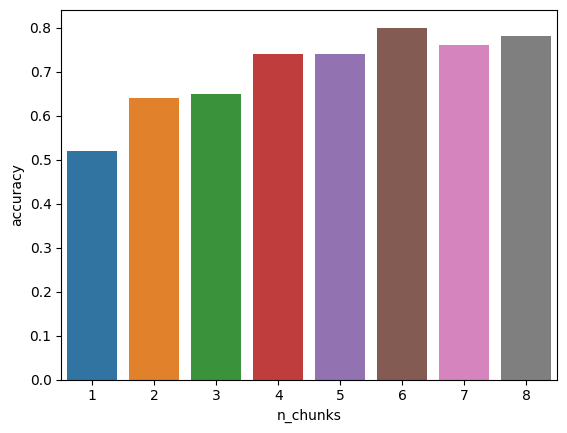

In [28]:
import seaborn as sns

sns.barplot(x='n_chunks', y='accuracy', data=metrics_df)

In [29]:
save_path = os.path.join(expr_dir, 'eval_dfs.pkl')

if not os.path.exists(save_path):
    print(f'saving to {save_path}')
    pickle.dump(pred_dfs, open(save_path, 'wb'))

saving to ../experiments/retrieval_v12_partor/eval_dfs.pkl
